<a href="https://colab.research.google.com/github/bforoura/AI/blob/main/Module7/Natural_Language_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Natural Language Processing (NLP) in TensorFlow**

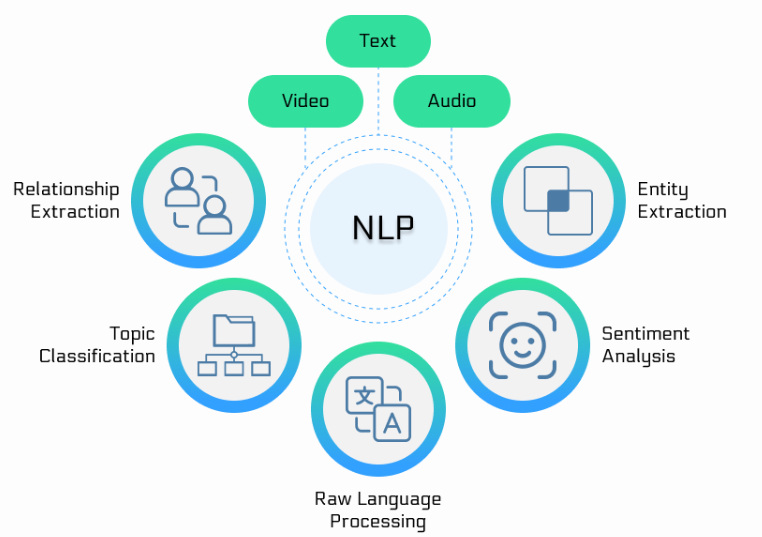

## Introduction

This tutorial is about a basic form of Natural Language Processing (NLP) called Sentiment Analysis, in which we will try and classify a movie review as either positive or negative.

Consider a simple example: "This movie is not very good." This text ends with the words "very good" which indicates a very positive sentiment, but it is negated because it is preceded by the word "not", so the text should be classified as having a negative sentiment. How can we teach a Neural Network to do this classification?

Another problem is that neural networks cannot work directly on text-data, so we need to convert text into numbers that are compatible with a neural network.

Yet another problem is that a text may be arbitrarily long. The neural networks we have worked with in previous tutorials use fixed data-shapes - except for the first dimension of the data which varies with the batch-size. Now we need a type of neural network that can work on both short and long sequences of text.

You should be familiar with TensorFlow and Keras in general, see Tutorials #01 and #03-C.

## Flowchart

To solve this problem we need several processing steps. First we need to convert the raw text-words into so-called tokens which are integer values. These tokens are really just indices into a list of the entire vocabulary. Then we convert these integer-tokens into so-called embeddings which are real-valued vectors, whose mapping will be trained along with the neural network, so as to map words with similar meanings to similar embedding-vectors. Then we input these embedding-vectors to a Recurrent Neural Network which can take sequences of arbitrary length as input and output a kind of summary of what it has seen in the input. This output is then squashed using a Sigmoid-function to give us a value between 0.0 and 1.0, where 0.0 is taken to mean a negative sentiment and 1.0 means a positive sentiment. This whole process allows us to classify input-text as either having a negative or positive sentiment.

The flowchart of the algorithm is roughly:

<img src="https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/20_natural_language_flowchart.png?raw=1" alt="Flowchart NLP" style="width: 300px;"/>

## Recurrent Neural Network

The basic building block in a Recurrent Neural Network (RNN) is a Recurrent Unit (RU). There are many different variants of recurrent units such as the rather clunky LSTM (Long-Short-Term-Memory) and the somewhat simpler GRU (Gated Recurrent Unit) which we will use in this tutorial. Experiments in the literature suggest that the LSTM and GRU have roughly similar performance. Even simpler variants also exist and the literature suggests that they may perform even better than both LSTM and GRU, but they are not implemented in Keras which we will use in this tutorial.

The following figure shows the abstract idea of a recurrent unit, which has an internal state that is being updated every time the unit receives a new input. This internal state serves as a kind of memory. However, it is not a traditional kind of computer memory which stores bits that are either on or off. Instead the recurrent unit stores floating-point values in its memory-state, which are read and written using matrix-operations so the operations are all differentiable. This means the memory-state can store arbitrary floating-point values (although typically limited between -1.0 and 1.0) and the network can be trained like a normal neural network using Gradient Descent.

The new state-value depends on both the old state-value and the current input. For example, if the state-value has memorized that we have recently seen the word "not" and the current input is "good" then we need to store a new state-value that memorizes "not good" which indicates a negative sentiment.

The part of the recurrent unit that is responsible for mapping old state-values and inputs to the new state-value is called a gate, but it is really just a type of matrix-operation. There is another gate for calculating the output-values of the recurrent unit. The implementation of these gates vary for different types of recurrent units. This figure merely shows the abstract idea of a recurrent unit. The LSTM has more gates than the GRU but some of them are apparently redundant so they can be omitted.

In order to train the recurrent unit, we must gradually change the weight-matrices of the gates so the recurrent unit gives the desired output for an input sequence. This is done automatically in TensorFlow.

![Recurrent unit](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/20_recurrent_unit.png?raw=1)

### Unrolled Network

Another way to visualize and understand a Recurrent Neural Network is to "unroll" the recursion. In this figure there is only a single recurrent unit denoted RU, which will receive a text-word from the input sequence in a series of time-steps.

The initial memory-state of the RU is reset to zero internally by Keras / TensorFlow every time a new sequence begins.

In the first time-step the word "this" is input to the RU which uses its internal state (initialized to zero) and its gate to calculate the new state. The RU also uses its other gate to calculate the output but it is ignored here because it is only needed at the end of the sequence to output a kind of summary.

In the second time-step the word "is" is input to the RU which now uses the internal state that was just updated from seeing the previous word "this".

There is not much meaning in the words "this is" so the RU probably doesn't save anything important in its internal state from seeing these words. But when it sees the third word "not" the RU has learned that it may be important for determining the overall sentiment of the input-text, so it needs to be stored in the memory-state of the RU, which can be used later when the RU sees the word "good" in time-step 6.

Finally when the entire sequence has been processed, the RU outputs a vector of values that summarizes what it has seen in the input sequence. We then use a fully-connected layer with a Sigmoid activation to get a single value between 0.0 and 1.0 which we interpret as the sentiment either being negative (values close to 0.0) or positive (values close to 1.0).

Note that for the sake of clarity, this figure doesn't show the mapping from text-words to integer-tokens and embedding-vectors, as well as the fully-connected Sigmoid layer on the output.

![Unrolled network](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/20_unrolled_flowchart.png?raw=1)

### 3-Layer Unrolled Network

In this tutorial we will use a Recurrent Neural Network with 3 recurrent units (or layers) denoted RU1, RU2 and RU3 in the "unrolled" figure below.

The first layer is much like the unrolled figure above for a single-layer RNN. First the recurrent unit RU1 has its internal state initialized to zero by Keras / TensorFlow. Then the word "this" is input to RU1 and it updates its internal state. Then it processes the next word "is", and so forth. But instead of outputting a single summary value at the end of the sequence, we use the output of RU1 for every time-step. This creates a new sequence that can then be used as input for the next recurrent unit RU2. The same process is repeated for the second layer and this creates a new output sequence which is then input to the third layer's recurrent unit RU3, whose final output is passed to a fully-connected Sigmoid layer that outputs a value between 0.0 (negative sentiment) and 1.0 (positive sentiment).

Note that for the sake of clarity, the mapping of text-words to integer-tokens and embedding-vectors has been omitted from this figure.

![Unrolled 3-layer network](https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/images/20_unrolled_3layers_flowchart.png?raw=1)

### Exploding & Vanishing Gradients

In order to train the weights for the gates inside the recurrent unit, we need to minimize some loss-function which measures the difference between the actual output of the network relative to the desired output.

From the "unrolled" figures above we see that the reccurent units are applied recursively for each word in the input sequence. This means the recurrent gate is applied once for each time-step. The gradient-signals have to flow back from the loss-function all the way to the first time the recurrent gate is used. If the gradient of the recurrent gate is multiplicative, then we essentially have an exponential function.

In this tutorial we will use texts that have more than 500 words. This means the RU's gate for updating its internal memory-state is applied recursively more than 500 times. If a gradient of just 1.01 is multiplied with itself 500 times then it gives a value of about 145. If a gradient of just 0.99 is multiplied with itself 500 times then it gives a value of about 0.007. These are called exploding and vanishing gradients. The only gradients that can survive recurrent multiplication are 0 and 1.

To avoid these so-called exploding and vanishing gradients, care must be made when designing the recurrent unit and its gates. That is why the actual implementation of the GRU is more complicated, because it tries to send the gradient back through the gates without this distortion.

## Imports

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from scipy.spatial.distance import cdist

We need to import several things from Keras.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

This was developed using Python 3.6 (Anaconda) and package versions:

In [ ]:
tf.__version__

'2.1.0'

In [ ]:
tf.keras.__version__

'2.2.4-tf'

## Load Data

We will use a data-set consisting of 50000 reviews of movies from IMDB. Keras has a built-in function for downloading a similar data-set (but apparently half the size). However, Keras' version has already converted the text in the data-set to integer-tokens, which is a crucial part of working with natural languages that will also be demonstrated in this tutorial, so we download the actual text-data.

NOTE: The data-set is 84 MB and will be downloaded automatically.

In [ ]:
import imdb

Change this if you want the files saved in another directory.

In [ ]:
# imdb.data_dir = "data/IMDB/"

Automatically download and extract the files.

In [ ]:
imdb.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.


Load the training- and test-sets.

In [ ]:
x_train_text, y_train = imdb.load_data(train=True)
x_test_text, y_test = imdb.load_data(train=False)

# Convert to numpy arrays.
y_train = np.array(y_train)
y_test = np.array(y_test)

In [ ]:
print("Train-set size: ", len(x_train_text))
print("Test-set size:  ", len(x_test_text))

Train-set size:  25000
Test-set size:   25000


Combine into one data-set for some uses below.

In [ ]:
data_text = x_train_text + x_test_text

Print an example from the training-set to see that the data looks correct.

In [ ]:
x_train_text[1]

'Return To the Lost World was filmed back-to-back with the 1992 version of The Lost World.<br /><br />In this sequel, the same five people, lead by Challenger return to the plateau where a group has started drilling for oil which is threatening to destroy the land. Gomez has something to do with this. They manage to defeat the drillers and the plateau is saved, much to the delight of the natives.<br /><br />Like in The Lost World, what few dinosaurs we see are made of rubber and these include a T-Rex and Ankylosaurus.<br /><br />John Ryhs-Davies and David Warner reprise their roles as Challenger and Summerlee and three of the other actors are also back.<br /><br />Despite reading several bad reviews of this and those cheap looking rubber dinosaurs, I enjoyed Return to the Lost World.<br /><br />Rating: 3 stars out of 5.'

The true "class" is a sentiment of the movie-review. It is a value of 0.0 for a negative sentiment and 1.0 for a positive sentiment. In this case the review is positive.

In [ ]:
y_train[1]

1.0

## Tokenizer

A neural network cannot work directly on text-strings so we must convert it somehow. There are two steps in this conversion, the first step is called the "tokenizer" which converts words to integers and is done on the data-set before it is input to the neural network. The second step is an integrated part of the neural network itself and is called the "embedding"-layer, which is described further below.

We may instruct the tokenizer to only use e.g. the 10000 most popular words from the data-set.

In [ ]:
num_words = 10000

In [ ]:
tokenizer = Tokenizer(num_words=num_words)

The tokenizer can then be "fitted" to the data-set. This scans through all the text and strips it from unwanted characters such as punctuation, and also converts it to lower-case characters. The tokenizer then builds a vocabulary of all unique words along with various data-structures for accessing the data.

Note that we fit the tokenizer on the entire data-set so it gathers words from both the training- and test-data. This is OK as we are merely building a vocabulary and want it to be as complete as possible. The actual neural network will of course only be trained on the training-set.

In [ ]:
%%time
tokenizer.fit_on_texts(data_text)

CPU times: user 8.21 s, sys: 33.2 ms, total: 8.25 s
Wall time: 8.25 s


If you want to use the entire vocabulary then set `num_words=None` above, and then it will automatically be set to the vocabulary-size here. (This is because of Keras' somewhat awkward implementation.)

In [ ]:
if num_words is None:
    num_words = len(tokenizer.word_index)

We can then inspect the vocabulary that has been gathered by the tokenizer. This is ordered by the number of occurrences of the words in the data-set. These integer-numbers are called word indices or "tokens" because they uniquely identify each word in the vocabulary.

In [ ]:
tokenizer.word_index

{'the': 1,
 'and': 2,
 'a': 3,
 'of': 4,
 'to': 5,
 'is': 6,
 'br': 7,
 'in': 8,
 'it': 9,
 'i': 10,
 'this': 11,
 'that': 12,
 'was': 13,
 'as': 14,
 'for': 15,
 'with': 16,
 'movie': 17,
 'but': 18,
 'film': 19,
 'on': 20,
 'not': 21,
 'you': 22,
 'are': 23,
 'his': 24,
 'have': 25,
 'be': 26,
 'one': 27,
 'he': 28,
 'all': 29,
 'at': 30,
 'by': 31,
 'an': 32,
 'they': 33,
 'so': 34,
 'who': 35,
 'from': 36,
 'like': 37,
 'or': 38,
 'just': 39,
 'her': 40,
 'out': 41,
 'about': 42,
 'if': 43,
 "it's": 44,
 'has': 45,
 'there': 46,
 'some': 47,
 'what': 48,
 'good': 49,
 'when': 50,
 'more': 51,
 'very': 52,
 'up': 53,
 'no': 54,
 'time': 55,
 'my': 56,
 'even': 57,
 'would': 58,
 'she': 59,
 'which': 60,
 'only': 61,
 'really': 62,
 'see': 63,
 'story': 64,
 'their': 65,
 'had': 66,
 'can': 67,
 'me': 68,
 'well': 69,
 'were': 70,
 'than': 71,
 'much': 72,
 'we': 73,
 'bad': 74,
 'been': 75,
 'get': 76,
 'do': 77,
 'great': 78,
 'other': 79,
 'will': 80,
 'also': 81,
 'into': 82,
 'p

We can then use the tokenizer to convert all texts in the training-set to lists of these tokens.

In [ ]:
x_train_tokens = tokenizer.texts_to_sequences(x_train_text)

For example, here is a text from the training-set:

In [ ]:
x_train_text[1]

'Return To the Lost World was filmed back-to-back with the 1992 version of The Lost World.<br /><br />In this sequel, the same five people, lead by Challenger return to the plateau where a group has started drilling for oil which is threatening to destroy the land. Gomez has something to do with this. They manage to defeat the drillers and the plateau is saved, much to the delight of the natives.<br /><br />Like in The Lost World, what few dinosaurs we see are made of rubber and these include a T-Rex and Ankylosaurus.<br /><br />John Ryhs-Davies and David Warner reprise their roles as Challenger and Summerlee and three of the other actors are also back.<br /><br />Despite reading several bad reviews of this and those cheap looking rubber dinosaurs, I enjoyed Return to the Lost World.<br /><br />Rating: 3 stars out of 5.'

This text corresponds to the following list of tokens:

In [ ]:
np.array(x_train_tokens[1])

array([1037,    5,    1,  432,  181,   13,  748,  141,    5,  141,   16,
          1, 7418,  318,    4,    1,  432,  181,    7,    7,    8,   11,
        751,    1,  167,  707,   83,  469,   31, 1037,    5,    1,  117,
          3,  547,   45,  654,   15, 3336,   60,    6, 3746,    5, 2222,
          1, 1379,   45,  137,    5,   77,   16,   11,   33, 1894,    5,
       4399,    1,    2,    1,    6, 2011,   72,    5,    1, 3029,    4,
          1, 5836,    7,    7,   37,    8,    1,  432,  181,   48,  171,
       3847,   73,   63,   23,   90,    4, 4118,    2,  132, 1469,    3,
        789, 4019,    2,    7,    7,  315, 4180,    2,  611, 2991,   65,
        578,   14,    2,    2,  277,    4,    1,   79,  150,   23,   81,
        141,    7,    7,  467,  899,  439,   74,  838,    4,   11,    2,
        143,  691,  256, 4118, 3847,   10,  511, 1037,    5,    1,  432,
        181,    7,    7,  670,  338,  405,   41,    4,  447])

We also need to convert the texts in the test-set to tokens.

In [ ]:
x_test_tokens = tokenizer.texts_to_sequences(x_test_text)

## Padding and Truncating Data

The Recurrent Neural Network can take sequences of arbitrary length as input, but in order to use a whole batch of data, the sequences need to have the same length. There are two ways of achieving this: (A) Either we ensure that all sequences in the entire data-set have the same length, or (B) we write a custom data-generator that ensures the sequences have the same length within each batch.

Solution (A) is simpler but if we use the length of the longest sequence in the data-set, then we are wasting a lot of memory. This is particularly important for larger data-sets.

So in order to make a compromise, we will use a sequence-length that covers most sequences in the data-set, and we will then truncate longer sequences and pad shorter sequences.

First we count the number of tokens in all the sequences in the data-set.

In [ ]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

The average number of tokens in a sequence is:

In [ ]:
np.mean(num_tokens)

221.27716

The maximum number of tokens in a sequence is:

In [ ]:
np.max(num_tokens)

2209

The max number of tokens we will allow is set to the average plus 2 standard deviations.

In [ ]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

544

This covers about 95% of the data-set.

In [ ]:
np.sum(num_tokens < max_tokens) / len(num_tokens)

0.94528

When padding or truncating the sequences that have a different length, we need to determine if we want to do this padding or truncating 'pre' or 'post'. If a sequence is truncated, it means that a part of the sequence is simply thrown away. If a sequence is padded, it means that zeros are added to the sequence.

So the choice of 'pre' or 'post' can be important because it determines whether we throw away the first or last part of a sequence when truncating, and it determines whether we add zeros to the beginning or end of the sequence when padding. This may confuse the Recurrent Neural Network.

In [ ]:
pad = 'pre'

In [ ]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens,
                            padding=pad, truncating=pad)

In [ ]:
x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)

We have now transformed the training-set into one big matrix of integers (tokens) with this shape:

In [ ]:
x_train_pad.shape

(25000, 544)

The matrix for the test-set has the same shape:

In [ ]:
x_test_pad.shape

(25000, 544)

For example, we had the following sequence of tokens above:

In [ ]:
np.array(x_train_tokens[1])

array([1037,    5,    1,  432,  181,   13,  748,  141,    5,  141,   16,
          1, 7418,  318,    4,    1,  432,  181,    7,    7,    8,   11,
        751,    1,  167,  707,   83,  469,   31, 1037,    5,    1,  117,
          3,  547,   45,  654,   15, 3336,   60,    6, 3746,    5, 2222,
          1, 1379,   45,  137,    5,   77,   16,   11,   33, 1894,    5,
       4399,    1,    2,    1,    6, 2011,   72,    5,    1, 3029,    4,
          1, 5836,    7,    7,   37,    8,    1,  432,  181,   48,  171,
       3847,   73,   63,   23,   90,    4, 4118,    2,  132, 1469,    3,
        789, 4019,    2,    7,    7,  315, 4180,    2,  611, 2991,   65,
        578,   14,    2,    2,  277,    4,    1,   79,  150,   23,   81,
        141,    7,    7,  467,  899,  439,   74,  838,    4,   11,    2,
        143,  691,  256, 4118, 3847,   10,  511, 1037,    5,    1,  432,
        181,    7,    7,  670,  338,  405,   41,    4,  447])

This has simply been padded to create the following sequence. Note that when this is input to the Recurrent Neural Network, then it first inputs a lot of zeros. If we had padded 'post' then it would input the integer-tokens first and then a lot of zeros. This may confuse the Recurrent Neural Network.

In [ ]:
x_train_pad[1]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

## Tokenizer Inverse Map

For some strange reason, the Keras implementation of a tokenizer does not seem to have the inverse mapping from integer-tokens back to words, which is needed to reconstruct text-strings from lists of tokens. So we make that mapping here.

In [ ]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

Helper-function for converting a list of tokens back to a string of words.

In [ ]:
def tokens_to_string(tokens):
    # Map from tokens back to words.
    words = [inverse_map[token] for token in tokens if token != 0]

    # Concatenate all words.
    text = " ".join(words)

    return text

For example, this is the original text from the data-set:

In [ ]:
x_train_text[1]

'Return To the Lost World was filmed back-to-back with the 1992 version of The Lost World.<br /><br />In this sequel, the same five people, lead by Challenger return to the plateau where a group has started drilling for oil which is threatening to destroy the land. Gomez has something to do with this. They manage to defeat the drillers and the plateau is saved, much to the delight of the natives.<br /><br />Like in The Lost World, what few dinosaurs we see are made of rubber and these include a T-Rex and Ankylosaurus.<br /><br />John Ryhs-Davies and David Warner reprise their roles as Challenger and Summerlee and three of the other actors are also back.<br /><br />Despite reading several bad reviews of this and those cheap looking rubber dinosaurs, I enjoyed Return to the Lost World.<br /><br />Rating: 3 stars out of 5.'

We can recreate this text except for punctuation and other symbols, by converting the list of tokens back to words:

In [ ]:
tokens_to_string(x_train_tokens[1])

'return to the lost world was filmed back to back with the 1992 version of the lost world br br in this sequel the same five people lead by return to the where a group has started for oil which is threatening to destroy the land has something to do with this they manage to defeat the and the is saved much to the delight of the natives br br like in the lost world what few dinosaurs we see are made of rubber and these include a t rex and br br john davies and david warner their roles as and and three of the other actors are also back br br despite reading several bad reviews of this and those cheap looking rubber dinosaurs i enjoyed return to the lost world br br rating 3 stars out of 5'

## Create the Recurrent Neural Network

We are now ready to create the Recurrent Neural Network (RNN). We will use the Keras API for this because of its simplicity. See Tutorial #03-C for a tutorial on Keras.

In [ ]:
model = Sequential()

The first layer in the RNN is a so-called Embedding-layer which converts each integer-token into a vector of values. This is necessary because the integer-tokens may take on values between 0 and 10000 for a vocabulary of 10000 words. The RNN cannot work on values in such a wide range. The embedding-layer is trained as a part of the RNN and will learn to map words with similar semantic meanings to similar embedding-vectors, as will be shown further below.

First we define the size of the embedding-vector for each integer-token. In this case we have set it to 8, so that each integer-token will be converted to a vector of length 8. The values of the embedding-vector will generally fall roughly between -1.0 and 1.0, although they may exceed these values somewhat.

The size of the embedding-vector is typically selected between 100-300, but it seems to work reasonably well with small values for Sentiment Analysis.

In [ ]:
embedding_size = 8

The embedding-layer also needs to know the number of words in the vocabulary (`num_words`) and the length of the padded token-sequences (`max_tokens`). We also give this layer a name because we need to retrieve its weights further below.

In [ ]:
model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_tokens,
                    name='layer_embedding'))

We can now add the first Gated Recurrent Unit (GRU) to the network. This will have 16 outputs. Because we will add a second GRU after this one, we need to return sequences of data because the next GRU expects sequences as its input.

In [ ]:
model.add(GRU(units=16, return_sequences=True))

This adds the second GRU with 8 output units. This will be followed by another GRU so it must also return sequences.

In [ ]:
model.add(GRU(units=8, return_sequences=True))

This adds the third and final GRU with 4 output units. This will be followed by a dense-layer, so it should only give the final output of the GRU and not a whole sequence of outputs.

In [ ]:
model.add(GRU(units=4))

Add a fully-connected / dense layer which computes a value between 0.0 and 1.0 that will be used as the classification output.

In [ ]:
model.add(Dense(1, activation='sigmoid'))

Use the Adam optimizer with the given learning-rate.

In [ ]:
optimizer = Adam(lr=1e-3)

Compile the Keras model so it is ready for training.

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer_embedding (Embedding)  (None, 544, 8)            80000     
_________________________________________________________________
gru (GRU)                    (None, 544, 16)           1248      
_________________________________________________________________
gru_1 (GRU)                  (None, 544, 8)            624       
_________________________________________________________________
gru_2 (GRU)                  (None, 4)                 168       
_________________________________________________________________
dense (Dense)                (None, 1)                 5         
Total params: 82,045
Trainable params: 82,045
Non-trainable params: 0
_________________________________________________________________


## Train the Recurrent Neural Network

We can now train the model. Note that we are using the data-set with the padded sequences. We use 5% of the training-set as a small validation-set, so we have a rough idea whether the model is generalizing well or if it is perhaps over-fitting to the training-set.

In [ ]:
%%time
model.fit(x_train_pad, y_train,
          validation_split=0.05, epochs=3, batch_size=64)

Train on 23750 samples, validate on 1250 samples
Epoch 1/3
23750/23750 [==============================] - 16s 690us/sample - loss: 0.4935 - accuracy: 0.7452 - val_loss: 0.3798 - val_accuracy: 0.8328
Epoch 2/3
23750/23750 [==============================] - 12s 510us/sample - loss: 0.2919 - accuracy: 0.8887 - val_loss: 0.3111 - val_accuracy: 0.8736
Epoch 3/3
23750/23750 [==============================] - 12s 511us/sample - loss: 0.2210 - accuracy: 0.9211 - val_loss: 0.3090 - val_accuracy: 0.8760
CPU times: user 48.9 s, sys: 1.58 s, total: 50.5 s
Wall time: 40.7 s


## Performance on Test-Set

Now that the model has been trained we can calculate its classification accuracy on the test-set.

In [ ]:
%%time
result = model.evaluate(x_test_pad, y_test)

25000/25000 [==============================] - 12s 493us/sample - loss: 0.3331 - accuracy: 0.8674
CPU times: user 14 s, sys: 404 ms, total: 14.4 s
Wall time: 12.4 s


In [ ]:
print("Accuracy: {0:.2%}".format(result[1]))

Accuracy: 86.74%


## Example of Mis-Classified Text

In order to show an example of mis-classified text, we first calculate the predicted sentiment for the first 1000 texts in the test-set.

In [ ]:
%%time
y_pred = model.predict(x=x_test_pad[0:1000])
y_pred = y_pred.T[0]

CPU times: user 1.08 s, sys: 23.5 ms, total: 1.1 s
Wall time: 1.03 s


These predicted numbers fall between 0.0 and 1.0. We use a cutoff / threshold and say that all values above 0.5 are taken to be 1.0 and all values below 0.5 are taken to be 0.0. This gives us a predicted "class" of either 0.0 or 1.0.

In [ ]:
cls_pred = np.array([1.0 if p>0.5 else 0.0 for p in y_pred])

The true "class" for the first 1000 texts in the test-set are needed for comparison.

In [ ]:
cls_true = np.array(y_test[0:1000])

We can then get indices for all the texts that were incorrectly classified by comparing all the "classes" of these two arrays.

In [ ]:
incorrect = np.where(cls_pred != cls_true)
incorrect = incorrect[0]

Of the 1000 texts used, how many were mis-classified?

In [ ]:
len(incorrect)

132

Let us look at the first mis-classified text. We will use its index several times.

In [ ]:
idx = incorrect[0]
idx

18

The mis-classified text is:

In [ ]:
text = x_test_text[idx]
text

"This HAS to be my guilty pleasure. I am a HUGE fan of 80's movies that were designed to entertain and they didn't care if they offended anyone. This move has no meat, not substance, no deep thought provoking scenes. Just plain old college kids having fun and if a few breasts have to be shown, then so be it! This movie is for when you just want to relax and NOT think. Viva la nudity!"

These are the predicted and true classes for the text:

In [ ]:
y_pred[idx]

0.27373913

In [ ]:
cls_true[idx]

1.0

## New Data

Let us try and classify new texts that we make up. Some of these are obvious, while others use negation and sarcasm to try and confuse the model into mis-classifying the text.

In [ ]:
text1 = "This movie is fantastic! I really like it because it is so good!"
text2 = "Good movie!"
text3 = "Maybe I like this movie."
text4 = "Meh ..."
text5 = "If I were a drunk teenager then this movie might be good."
text6 = "Bad movie!"
text7 = "Not a good movie!"
text8 = "This movie really sucks! Can I get my money back please?"
texts = [text1, text2, text3, text4, text5, text6, text7, text8]

We first convert these texts to arrays of integer-tokens because that is needed by the model.

In [ ]:
tokens = tokenizer.texts_to_sequences(texts)

To input texts with different lengths into the model, we also need to pad and truncate them.

In [ ]:
tokens_pad = pad_sequences(tokens, maxlen=max_tokens,
                           padding=pad, truncating=pad)
tokens_pad.shape

(8, 544)

We can now use the trained model to predict the sentiment for these texts.

In [ ]:
model.predict(tokens_pad)

array([[0.95301837],
       [0.92733926],
       [0.79257476],
       [0.9019553 ],
       [0.5875022 ],
       [0.55110747],
       [0.89896274],
       [0.33616564]], dtype=float32)

A value close to 0.0 means a negative sentiment and a value close to 1.0 means a positive sentiment. These numbers will vary every time you train the model.

## Embeddings

The model cannot work on integer-tokens directly, because they are integer values that may range between 0 and the number of words in our vocabulary, e.g. 10000. So we need to convert the integer-tokens into vectors of values that are roughly between -1.0 and 1.0 which can be used as input to a neural network.

This mapping from integer-tokens to real-valued vectors is also called an "embedding". It is essentially just a matrix where each row contains the vector-mapping of a single token. This means we can quickly lookup the mapping of each integer-token by simply using the token as an index into the matrix. The embeddings are learned along with the rest of the model during training.

Ideally the embedding would learn a mapping where words that are similar in meaning also have similar embedding-values. Let us investigate if that has happened here.

First we need to get the embedding-layer from the model:

In [ ]:
layer_embedding = model.get_layer('layer_embedding')

We can then get the weights used for the mapping done by the embedding-layer.

In [ ]:
weights_embedding = layer_embedding.get_weights()[0]

Note that the weights are actually just a matrix with the number of words in the vocabulary times the vector length for each embedding. That's because it is basically just a lookup-matrix.

In [ ]:
weights_embedding.shape

(10000, 8)

Let us get the integer-token for the word 'good', which is just an index into the vocabulary.

In [ ]:
token_good = tokenizer.word_index['good']
token_good

49

Let us also get the integer-token for the word 'great'.

In [ ]:
token_great = tokenizer.word_index['great']
token_great

78

These integertokens may be far apart and will depend on the frequency of those words in the data-set.

Now let us compare the vector-embeddings for the words 'good' and 'great'. Several of these values are similar, although some values are quite different. Note that these values will change every time you train the model.

In [ ]:
weights_embedding[token_good]

array([ 0.01839033,  0.05229224,  0.0848575 ,  0.03222338, -0.03947427,
       -0.03776564, -0.01149088, -0.07443853], dtype=float32)

In [ ]:
weights_embedding[token_great]

array([-0.14307617,  0.08333486,  0.15650608,  0.08930028, -0.08659173,
       -0.12289459, -0.14367667, -0.10402057], dtype=float32)

Similarly, we can compare the embeddings for the words 'bad' and 'horrible'.

In [ ]:
token_bad = tokenizer.word_index['bad']
token_horrible = tokenizer.word_index['horrible']

In [ ]:
weights_embedding[token_bad]

array([ 0.05553182, -0.09014519, -0.06248455, -0.11525143,  0.14601274,
        0.07451952,  0.10784499,  0.10799433], dtype=float32)

In [ ]:
weights_embedding[token_horrible]

array([ 0.15100664, -0.13359004, -0.15154287, -0.12776676,  0.10830297,
        0.15224072,  0.13508266,  0.14284784], dtype=float32)

### Sorted Words

We can also sort all the words in the vocabulary according to their "similarity" in the embedding-space. We want to see if words that have similar embedding-vectors also have similar meanings.

Similarity of embedding-vectors can be measured by different metrics, e.g. Euclidean distance or cosine distance.

We have a helper-function for calculating these distances and printing the words in sorted order.

In [ ]:
def print_sorted_words(word, metric='cosine'):
    """
    Print the words in the vocabulary sorted according to their
    embedding-distance to the given word.
    Different metrics can be used, e.g. 'cosine' or 'euclidean'.
    """

    # Get the token (i.e. integer ID) for the given word.
    token = tokenizer.word_index[word]

    # Get the embedding for the given word. Note that the
    # embedding-weight-matrix is indexed by the word-tokens
    # which are integer IDs.
    embedding = weights_embedding[token]

    # Calculate the distance between the embeddings for
    # this word and all other words in the vocabulary.
    distances = cdist(weights_embedding, [embedding],
                      metric=metric).T[0]

    # Get an index sorted according to the embedding-distances.
    # These are the tokens (integer IDs) for words in the vocabulary.
    sorted_index = np.argsort(distances)

    # Sort the embedding-distances.
    sorted_distances = distances[sorted_index]

    # Sort all the words in the vocabulary according to their
    # embedding-distance. This is a bit excessive because we
    # will only print the top and bottom words.
    sorted_words = [inverse_map[token] for token in sorted_index
                    if token != 0]

    # Helper-function for printing words and embedding-distances.
    def _print_words(words, distances):
        for word, distance in zip(words, distances):
            print("{0:.3f} - {1}".format(distance, word))

    # Number of words to print from the top and bottom of the list.
    k = 10

    print("Distance from '{0}':".format(word))

    # Print the words with smallest embedding-distance.
    _print_words(sorted_words[0:k], sorted_distances[0:k])

    print("...")

    # Print the words with highest embedding-distance.
    _print_words(sorted_words[-k:], sorted_distances[-k:])

We can then print the words that are near and far from the word 'great' in terms of their vector-embeddings. Note that these may change each time you train the model.

In [ ]:
print_sorted_words('great', metric='cosine')

Distance from 'great':
0.000 - great
0.012 - spring
0.013 - 1980
0.013 - permanent
0.013 - robinson
0.015 - anime
0.015 - pleasantly
0.016 - inter
0.016 - profit
0.017 - ramones
...
1.988 - mst3k
1.988 - consist
1.988 - save
1.989 - unless
1.990 - ripoff
1.991 - insipid
1.994 - avoid
1.995 - drivel
1.995 - expand
1.995 - profile


Similarly, we can print the words that are near and far from the word 'worst' in terms of their vector-embeddings.

In [ ]:
print_sorted_words('worst', metric='cosine')

Distance from 'worst':
0.000 - worst
0.004 - horrible
0.004 - dull
0.005 - below
0.005 - boredom
0.006 - conceived
0.008 - salvage
0.009 - slapped
0.009 - fails
0.010 - virus
...
1.989 - cried
1.989 - compelling
1.990 - carell
1.990 - stadium
1.991 - deanna
1.992 - eddie
1.992 - resolved
1.992 - sirk
1.994 - sidney
1.997 - concentrates
